In [1]:
import os
import gzip
import json
import datetime
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm
from collections import Counter
from operator import itemgetter

from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.autograd.set_detect_anomaly(True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%matplotlib inline

DATA_PATH = '../data/phone_data.json.gz'
MODEL_SAVE_PATH = '../models/seq2seq_attn_1024.pt'
RANDOM_SEED = 0

In [5]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(RANDOM_SEED)

### Load the data

In [6]:
def gzip2json(path):
    with gzip.GzipFile(path, 'r') as fin:
        data = json.loads(fin.read().decode('utf-8'))
    return data

In [7]:
data = gzip2json(DATA_PATH)

In [8]:
words, letters, phones, str_poss = [], [], [], []
ignored = 0
phoneme_ignore_list = ['#', "#́'", "{и^е}'", "{о^у}'", "о'", "ґ'", 
                       "{дж}'", "п:", "ц:", "ц':", "з':", "ш:", "р':", "м':", 
                       "ф:", "г:", "к':", "ш':", "п':", "б':", "ч:", "ф':", "х:"]

for item in tqdm(data):
    word = item['word'].lower()
    ltrs = [letter for letter in word]
    phns = [phone.replace(chr(769), '') for phone in item['phones']]
    stress_pos = [1 if chr(769) in item else 0 for item in item['phones']]
    
    # ignore words with rare phonemes
    if any(_ in ' '.join(phns) for _ in phoneme_ignore_list):
        ignored += 1
        continue
    
    # ignore words with more then 1 stress
#     if sum(stress_pos) > 1:
#         ignored += 1
#         continue
       
    words.append(word)
    letters.append(ltrs)
    phones.append(phns)
    str_poss.append(stress_pos)

data_preprocessed = pd.DataFrame(list(zip(words, letters, phones, str_poss)), 
                                 columns=["word", "letters", "phonemes", "stress_pos"])

100%|██████████| 160385/160385 [00:04<00:00, 39619.77it/s]


In [9]:
print(ignored)

509


In [10]:
data_preprocessed.sample(5)

,word,letters,phonemes,stress_pos
77619,молякевич,"[м, о, л, я, к, е, в, и, ч]","[м, о, л', а, к, е, в, {и^е}, ч]","[0, 0, 0, 0, 0, 1, 0, 0, 0]"
143414,тралити,"[т, р, а, л, и, т, и]","[т, р, а, л, {и^е}, т, {и^е}]","[0, 0, 1, 0, 0, 0, 0]"
101005,переслатися,"[п, е, р, е, с, л, а, т, и, с, я]","[п, {е^и}, р, {е^и}, с, л, а, т, {и^е}, с', а]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2533,амністія,"[а, м, н, і, с, т, і, я]","[а, м, н', і, с', т', і, й, а]","[0, 0, 0, 1, 0, 0, 0, 0, 0]"
11049,болотня,"[б, о, л, о, т, н, я]","[б, о, л, о, т', н', а]","[0, 0, 0, 1, 0, 0, 0]"


In [11]:
max_seq_len_encoder = np.max(data_preprocessed.letters.map(len))
max_seq_len_decoder = np.max(data_preprocessed.phonemes.map(len))
max_seq_len_encoder, max_seq_len_decoder

(33, 31)

### Preprocess

In [12]:
def flatten(array):
    for item in array:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

In [13]:
OOV_TOKEN, OOV_TOKEN_INDEX = "<UNK>", 1
SOS_TOKEN, SOS_TOKEN_INDEX = "<SOS>", 2
EOS_TOKEN, EOS_TOKEN_INDEX = "<EOS>", 3


class SequenceTokenizer:
    
    def __init__(self):
        self.word2index = {OOV_TOKEN: OOV_TOKEN_INDEX, 
                           SOS_TOKEN: SOS_TOKEN_INDEX, 
                           EOS_TOKEN: EOS_TOKEN_INDEX}
        self.index2word = {v: k for k, v in self.word2index.items()}
        self.word_counter = Counter()
        

    def fit(self, sequence):
        for item in sequence:
            self.word_counter.update(Counter(item))
        unique_words = sorted(self.word_counter.keys())
        self.word2index.update(dict(zip(unique_words, 
                                        range(len(self.word2index) + 1, 
                                              len(unique_words) + len(self.word2index) + 1))))
        self.index2word = {v: k for k, v in self.word2index.items()}
        
    
    def transform(self, X):
        res = []
        for line in X:
            res.append([self.word2index.get(item, OOV_TOKEN_INDEX) for item in line])
        return res

In [14]:
def pad_sequence(lst, max_sequence_len):
    if isinstance(lst[0], list):
        return np.array([i + [0]*(max_sequence_len-len(i)) for i in lst])
    else:
        lst + [0]*(max_sequence_len-len(lst))

        
def tokenize_sequence(tkn, sequence):
    return [tkn.word2index[word] for word in sequence]



def tensor_from_sequence(tkn, sequence):
    indexes = tokenize_sequence(tkn, sequence)
    indexes.append(EOS_TOKEN_INDEX)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensors_from_pair(seq1, seq2):
    input_tensor = tensor_from_sequence(input_tokenizer, seq1)
    target_tensor = tensor_from_sequence(output_tokenizer, seq2)
    return (input_tensor, target_tensor)

In [15]:
input_tokenizer = SequenceTokenizer()
input_tokenizer.fit(data_preprocessed.letters.values)

output_tokenizer = SequenceTokenizer()
output_tokenizer.fit(data_preprocessed.phonemes.values)

In [16]:
# sorted(input_tokenizer.word_counter.items(), key=itemgetter(1), reverse = True) 
# input_tokenizer.word2index

In [17]:
# sorted(output_tokenizer.word_counter.items(), key=itemgetter(1), reverse = True)
# output_tokenizer.word2index

In [18]:
max_seq_len_encoder += 1  # count EOS
max_seq_len_decoder += 2  # count SOS and EOS
max_seq_len = np.max([max_seq_len_encoder, max_seq_len_decoder]) + 1
max_seq_len

35

In [19]:
# data_preprocessed = data_preprocessed.loc[data_preprocessed.word.str.contains('ґ')]
# data_preprocessed

In [20]:
data = list(zip(data_preprocessed.letters.values[:100], data_preprocessed.phonemes.values[:100]))
input_sample, target_sample = random.choice(data)
input_sample, target_sample

(['а', 'б', 'и', 'я', 'к'], ['а', 'б', 'и', 'й', 'а', 'к'])

### Modeling

In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=max_seq_len):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Initialize the model

In [23]:
hidden_size = 1024

encoder = EncoderRNN(len(input_tokenizer.word2index) + 1, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, len(output_tokenizer.word2index) + 1).to(device)

In [24]:
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=1e-3)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=1e-3)

criterion = nn.NLLLoss()

#### Check the inference

In [25]:
print(input_sample, target_sample)
with torch.no_grad():
    input_tensor, target_tensor = tensors_from_pair(input_sample, target_sample)
    
    encoder_hidden = encoder.init_hidden()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_seq_len, encoder.hidden_size, device=device)
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_TOKEN_INDEX]], device=device)

    decoder_hidden = encoder_hidden
    
    decoded_word = []
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        decoded_word.append(topi.item())

        if decoder_input.item() == EOS_TOKEN_INDEX:
            break

[output_tokenizer.index2word.get(item, OOV_TOKEN) for item in decoded_word]

['а', 'б', 'и', 'я', 'к'] ['а', 'б', 'и', 'й', 'а', 'к']


['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', 'б:', 'б:']

#### Training the model

In [26]:
n_epochs = 20
history = {'train': {}, 'val': {}}
teacher_forcing_ratio = 0.5

for epoch in range(1, n_epochs + 1):
    start_time = time.time()
    
    train_data, val_data = train_test_split(data, test_size=0.1, random_state=random.randint(0, 1024))
    train_size, val_size = len(train_data), len(val_data)
    
    encoder.train()
    decoder.train()

    avg_loss, total_loss, avg_acc, total_acc = 0., 0., 0., 0.
    decoded_words_num = 0
    for iter_num, (letters, phonemes) in enumerate(train_data, 1):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

    
        input_tensor, target_tensor = tensors_from_pair(letters, phonemes)

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        
        loss = 0
        
        #############################################################################
        #############################################################################
        
        encoder_hidden = encoder.init_hidden()
        encoder_outputs = torch.zeros(max_seq_len, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
            
        #############################################################################
        #############################################################################

        decoder_input = torch.tensor([[SOS_TOKEN_INDEX]], device=device)
        decoder_hidden = encoder_hidden
        
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        decoded_word = []
        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):

                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += criterion(decoder_output, target_tensor[di])

                decoded_word.append(topi.item())

                if decoder_input.item() == EOS_TOKEN_INDEX:
                    break

        if len(decoded_word) != 0:
            decoded_words_tensor = torch.tensor(decoded_word, dtype=torch.long, device=device).view(-1, 1)
            acc = int(torch.equal(decoded_words_tensor, target_tensor))
            total_acc += acc
            decoded_words_num += 1
                    
        #############################################################################
        #############################################################################

        loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item() / target_length
        avg_loss = total_loss / iter_num
        if decoded_words_num == 0:
            avg_acc = 0
        else:
            avg_acc = total_acc / decoded_words_num
        
        current_progress = iter_num/train_size
        elapsed_time = np.ceil(time.time() - start_time)
        estimated_time = np.ceil(elapsed_time/current_progress)
        
        print(f"\rEpoch [{epoch}/{n_epochs}] "
              f" [{iter_num}/{train_size}] "
              f" [{str(datetime.timedelta(seconds=elapsed_time))}<{str(datetime.timedelta(seconds=estimated_time))}, "
              f" {iter_num/elapsed_time:.2f} it/s]"
              f"   loss={avg_loss:.4f} "
              f"   acc={avg_acc*100:.2f}% ", end='')
        
    history['train']['loss'] = history.get('train', {}).get('loss', []) + [avg_loss]
    history['train']['accuracy'] = history.get('train', {}).get('accuracy', []) + [avg_acc]
    
    encoder.eval()
    decoder.eval()
    
    
    avg_val_loss, total_val_loss, avg_val_acc, total_val_acc = 0., 0., 0., 0.
    for iter_num, (letters, phonemes) in enumerate(val_data, 1):
    
        input_tensor, target_tensor = tensors_from_pair(letters, phonemes)

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        
        val_loss = 0
        
        #############################################################################
        #############################################################################
        
        encoder_hidden = encoder.init_hidden()
        encoder_outputs = torch.zeros(max_seq_len, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
            
        #############################################################################
        #############################################################################

        decoder_input = torch.tensor([[SOS_TOKEN_INDEX]], device=device)
        decoder_hidden = encoder_hidden
        
        decoded_word = []
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            val_loss += criterion(decoder_output, target_tensor[di])

            decoded_word.append(topi.item())

            if decoder_input.item() == EOS_TOKEN_INDEX:
                break
        decoded_words_tensor = torch.tensor(decoded_word, dtype=torch.long, device=device).view(-1, 1)
        val_acc = int(torch.equal(decoded_words_tensor, target_tensor))
                    
        #############################################################################
        #############################################################################

        total_val_acc += val_acc
        total_val_loss += val_loss.item() / target_length   
        
        
    avg_val_loss = total_val_loss / val_size
    avg_val_acc = total_val_acc / val_size
    history['val']['loss'] = history.get('val', {}).get('loss', []) + [avg_val_loss]
    history['val']['accuracy'] = history.get('val', {}).get('accuracy', []) + [avg_val_acc]
    
    elapsed_time = time.time() - start_time 
    print(f"\nEpoch [{epoch}/{n_epochs}]  results:"
          f"\t loss={avg_loss:.4f}"
          f"\t acc={avg_acc * 100:.2f}%"
          f"\t val_loss={avg_val_loss:.4f}"
          f"\t val_acc={avg_val_acc * 100:.2f}%"
          f"\t time={elapsed_time:.2f}s")
    print("-"*78)

Epoch [1/20]  [90/90]  [0:00:16<0:00:16,  5.62 it/s]   loss=3.1594    acc=0.00% 
Epoch [1/20]  results:	 loss=3.1594	 acc=0.00%	 val_loss=2.5966	 val_acc=0.00%	 time=16.34s
------------------------------------------------------------------------------
Epoch [2/20]  [90/90]  [0:00:15<0:00:15,  6.00 it/s]   loss=2.4125    acc=0.00% 
Epoch [2/20]  results:	 loss=2.4125	 acc=0.00%	 val_loss=1.9640	 val_acc=0.00%	 time=15.85s
------------------------------------------------------------------------------
Epoch [3/20]  [90/90]  [0:00:15<0:00:15,  6.00 it/s]   loss=2.2003    acc=0.00% 
Epoch [3/20]  results:	 loss=2.2003	 acc=0.00%	 val_loss=1.9392	 val_acc=0.00%	 time=15.84s
------------------------------------------------------------------------------
Epoch [4/20]  [90/90]  [0:00:16<0:00:16,  5.62 it/s]   loss=2.1988    acc=0.00% 
Epoch [4/20]  results:	 loss=2.1988	 acc=0.00%	 val_loss=2.3157	 val_acc=0.00%	 time=16.56s
-----------------------------------------------------------------------

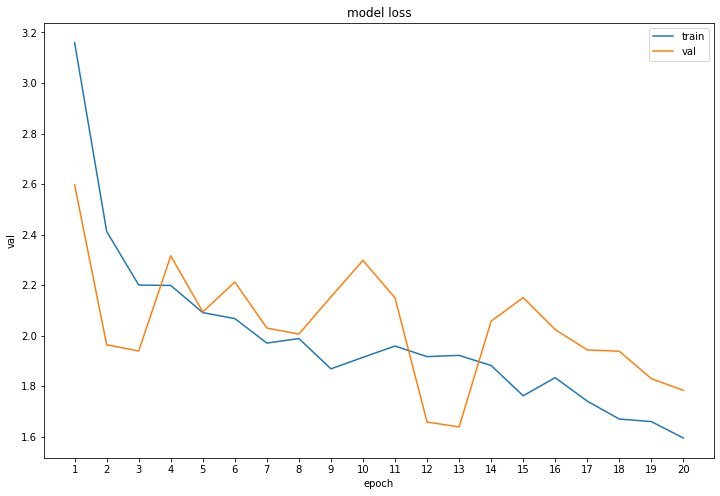

In [27]:
plt.figure(figsize=(12, 8))

plt.plot(history['train']['loss'])
plt.plot(history['val']['loss'])
plt.title('model loss')
plt.ylabel('val')
plt.xlabel('epoch')
plt.xticks(np.arange(len(history['train']['loss'])), np.arange(1, len(history['train']['loss']) + 1))
plt.legend(['train', 'val'], loc='upper right')

plt.show()

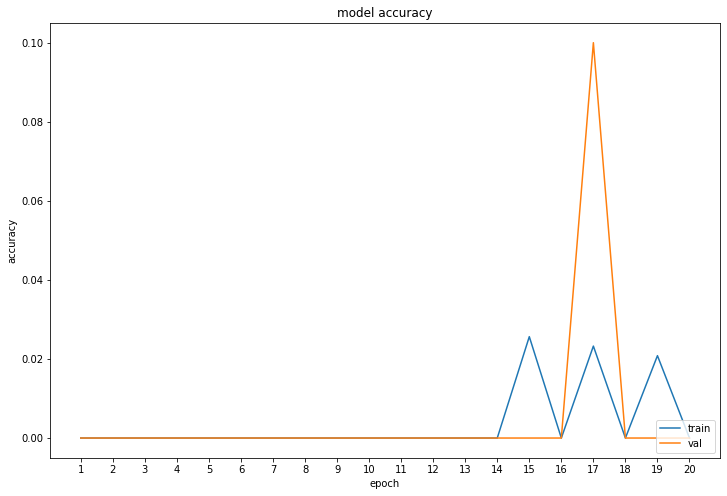

In [28]:
plt.figure(figsize=(12, 8))

plt.plot(history['train']['accuracy'])
plt.plot(history['val']['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(len(history['train']['accuracy'])), np.arange(1, len(history['train']['accuracy']) + 1))
plt.legend(['train', 'val'], loc='lower right')

plt.show()

#### Save the model

In [29]:
torch.save({'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict()}, MODEL_SAVE_PATH)

In [30]:
checkpoint = torch.load(MODEL_SAVE_PATH)
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

encoder.eval()
decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(78, 1024)
  (attn): Linear(in_features=2048, out_features=35, bias=True)
  (attn_combine): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(1024, 1024)
  (out): Linear(in_features=1024, out_features=78, bias=True)
)

### Validate the results

In [31]:
def evaluate(sentence):
    input_tensor = tensor_from_sequence(input_tokenizer, sentence)

    input_length = input_tensor.size(0)

    #############################################################################
    #############################################################################

    encoder_hidden = encoder.init_hidden()
    encoder_outputs = torch.zeros(max_seq_len, encoder.hidden_size, device=device)

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    #############################################################################
    #############################################################################

    decoder_input = torch.tensor([[SOS_TOKEN_INDEX]], device=device)
    decoder_hidden = encoder_hidden

    decoded_word = []
    decoder_attentions = torch.zeros(max_seq_len, max_seq_len)
    for di in range(max_seq_len):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()

        decoded_word.append(topi.item())

        if decoder_input.item() == EOS_TOKEN_INDEX:
            break
    decoded_word = [output_tokenizer.index2word[item] for item in decoded_word]
    return decoded_word, decoder_attentions[:di + 1]

In [36]:
# def evaluate(sentence, max_length=max_seq_len):
#     with torch.no_grad():
#         input_tensor = tensor_from_sequence(input_tokenizer, sentence)
#         input_length = input_tensor.size()[0]
#         encoder_hidden = encoder.init_hidden()

#         encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

#         for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei],
#                                                      encoder_hidden)
#             encoder_outputs[ei] += encoder_output[0, 0]

#         decoder_input = torch.tensor([[SOS_TOKEN_INDEX]], device=device)  # SOS

#         decoder_hidden = encoder_hidden

#         decoded_words = []
#         decoder_attentions = torch.zeros(max_length, max_length)

#         for di in range(max_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             decoder_attentions[di] = decoder_attention.data
#             topv, topi = decoder_output.data.topk(1)
#             if topi.item() == EOS_TOKEN_INDEX:
#                 decoded_words.append(EOS_TOKEN)
#                 break
#             else:
#                 decoded_words.append(output_tokenizer.index2word[topi.item()])

#             decoder_input = topi.squeeze().detach()

#         return decoded_words, decoder_attentions[:di + 1]
    
def show_attention(input_sequence, output_sequence, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sequence +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_sequence)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    

def evaluate_and_show_attention(sequence):
    output_sequence, attentions = evaluate(sequence)
    print('input =', sequence)
    print('output =', output_sequence[:-1])
    show_attention(sequence, output_sequence, attentions)

In [37]:
test_sample = ['а', 'г', 'і', 'т', 'а', 'т', 'о', 'р', 'с', 'ь', 'к', 'и', 'й']
test_sample

['а', 'г', 'і', 'т', 'а', 'т', 'о', 'р', 'с', 'ь', 'к', 'и', 'й']

In [38]:
evaluate(test_sample)[0]

['а', 'б', '{е^и}', 'р', 'а', '<EOS>']

input = ['а', 'г', 'і', 'т', 'а', 'т', 'о', 'р', 'с', 'ь', 'к', 'и', 'й']
output = ['а', 'б', '{е^и}', 'р', 'а']


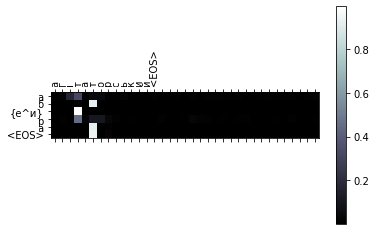

In [39]:
evaluate_and_show_attention(test_sample)